References Heap:

* https://grok.com/chat/f385ae74-8e66-4190-b8a2-086eb7b496bd

* https://msc.fema.gov/portal/advanceSearch#searchresultsanchor

* https://www.fema.gov/sites/default/files/documents/fema_flood-risk-products-technical.pdf
* https://hazards.fema.gov/femaportal/wps/portal/NFHLWMS
* https://www.fema.gov/flood-maps/guidance-reports/guidelines-standards/technical-references-flood-risk-analysis-and-mapping
    * https://www.fema.gov/sites/default/files/documents/fema_rm-firm-database-technical-reference-nov-2023.pdf
    * https://www.fema.gov/sites/default/files/documents/fema_technical_reference_flood_risk_database_frd_nov_2024.pdf#page=14.75
    * https://www.fema.gov/sites/default/files/2020-02/Flood_Risk_Database_Technical_Reference_Feb_2018.pdf
    * https://www.fema.gov/sites/default/files/nepa/Procedure_Memorandum_65-Amending_the_Guidelines_and_Standards_for_Flood_Hazard_Mapping_Partners__Mar_2011_.pdf

* https://hazards.fema.gov/femaportal/NFHL/searchResult/
* https://hazards.fema.gov/femaportal/wps/portal/NFHLWMS
* https://www.fema.gov/sites/default/files/2020-02/NFHL_Guidance_Feb_2019.pdf#page=14.36
* https://www.fema.gov/sites/default/files/documents/fema_depth-grids-technical.pdf

---

Possibly Useful
* https://www.fema.gov/flood-maps/national-flood-hazard-layer

In [1]:
import logging
import os
import pathlib
from typing import Dict, List, Tuple, Set

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyogrio
import shapely
from shapely.geometry import box, MultiPolygon, Polygon, LineString, MultiLineString
from shapely.ops import unary_union
from shapely.strtree import STRtree

In [2]:
floodplains_gpkg_path = os.path.join('../data/raw/avail/merged_floodplains/hazmit_db.s379_v841_avail_nys_floodplains_merged.1730233335.gpkg.zip')

# geoid = '36001'
# osm_pbf = os.path.join('../../../data/processed/osm/nonservice-roadways-buffer-10mi-county-36001_nonservice-roadways-buffer-50mi-state-36_us-250101.osm.pbf')

# geoid = '36001002500'
# osm_pbf = os.path.join('../../../data/processed/osm/nonservice-roadways-buffer-10mi-census-tract-36001002500_nonservice-roadways-buffer-10mi-county-36001_nonservice-roadways-buffer-50mi-state-36_us-250101.osm.pbf')

geoid = "36001001100"
osm_pbf = os.path.join('../../../data/processed/osm/nonservice-roadways-buffer-10mi-census-tract-36001001100_nonservice-roadways-buffer-10mi-county-36001_nonservice-roadways-buffer-50mi-state-36_us-250101.osm.pbf')

# buffer_dist_mi = 10


In [3]:
##### Imports Config #####
%load_ext autoreload
%autoreload 

from common.osm.enrich import create_enriched_osmnx_graph_for_region

In [4]:
# Configure logging (you can customize this)
logging.basicConfig(
    level=logging.WARNING, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [5]:
d = create_enriched_osmnx_graph_for_region(
    osm_pbf=osm_pbf,
)

geoid = d["geoid"]
buffer_dist_mi = d["buffer_dist_mi"]
edges_gdf = d['edges_gdf']
nodes_gdf = d['nodes_gdf']
region_gdf = d['region_gdf']
buffered_region_gdf = d['buffered_region_gdf']
region_name = d['region_name']

<Axes: >

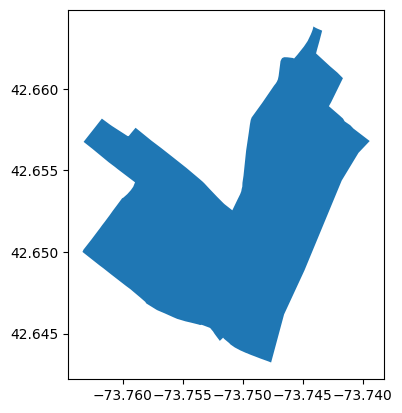

In [6]:
region_gdf.plot()

In [7]:
def show_gdfs(
    poly_gdfs,
    figsize=(10, 10),
    colors=None,
    alpha=None,
    linewidths=None,
    add_basemaps=True
):
    fig, ax = plt.subplots(figsize=figsize)

    for i, gdf in enumerate(poly_gdfs):
        gdf.plot(
            ax=ax,
            alpha=alpha[i] if alpha else 0.25,
            color=colors[i] if colors else 'blue',
            linewidth=linewidths[i] if linewidths else 2
        )

    if add_basemaps:
        cx.add_basemap(
            ax,
            crs=gdf.crs,
            source=cx.providers.Esri.WorldShadedRelief,
            attribution='',
            alpha=1,
        )

        cx.add_basemap(
            ax,
            crs=region_gdf.crs,
            source=cx.providers.OpenTopoMap,
            attribution='',
            alpha=0.2,
        )

        cx.add_attribution(
            ax=ax,
            text=(
                'Hillshade: ' 
                + cx.providers.Esri.WorldShadedRelief.attribution
                + '\n'
                + 'Topography: '
                + cx.providers.OpenTopoMap.attribution
            )
        )


    ax.set_axis_off() # Remove axis ticks and labels
    plt.show()


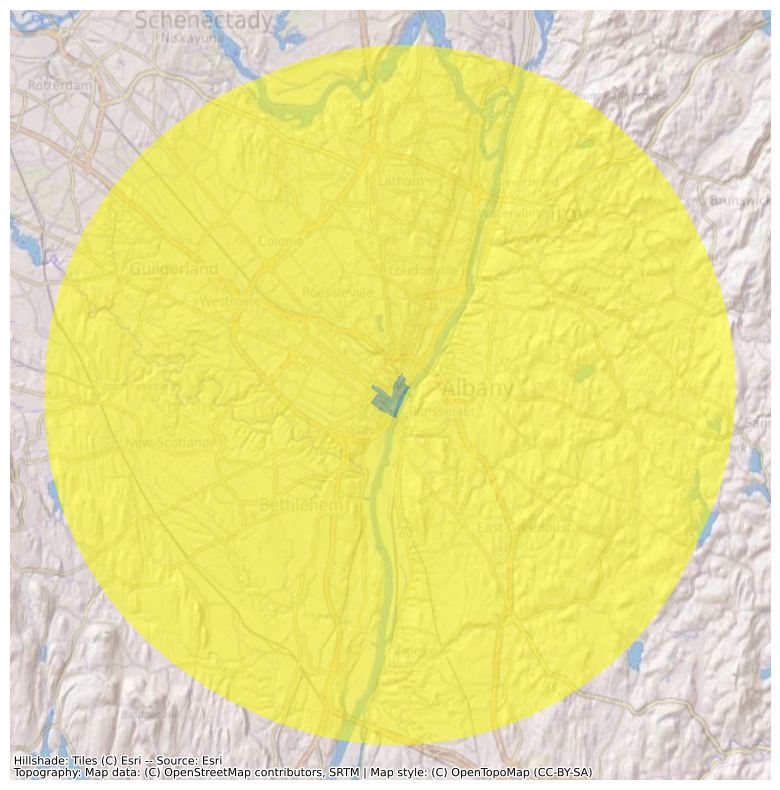

In [8]:
show_gdfs(
    poly_gdfs=[
        region_gdf,
        buffered_region_gdf.overlay(region_gdf, how='difference'),
    ],
    colors=['green', 'yellow'],
    alpha=[0.25, 0.5]
)

In [ ]:
def get_clipped_floodplain_data(
    floodplains_gpkg_path: pathlib.Path,
    buffered_region_gdf: gpd.GeoDataFrame,
):
    """
    Extract and clip floodplain data for a specific region.

    Parameters:
        floodplains_gpkg_path (str): Path to the zipped geopackage containing floodplain data
        floodplains_info (dict): Dictionary containing CRS information for the floodplain data
        buffered_region_gdf (GeoDataFrame): Buffer area around the region of interest
        region_gdf (GeoDataFrame): The region of interest

    Returns:
        GeoDataFrame: Floodplain data clipped to the region boundaries
    """

    # Verify buffered region has data
    if buffered_region_gdf.empty:
        raise ValueError("Buffered region GeoDataFrame is empty")

    # Read the floodplain data to get CRS information.
    #   Note: When using the GeoPandas.read_file method with the pyogrio engine,
    #         the mask's CRS MUST match the dataset's CRS.
    floodplains_info = pyogrio.read_info(
        floodplains_gpkg_path,
        engine='pyogrio',
        layer='merged_floodplains',
        force_feature_count=False,
        limit=0
    )

    # Convert the buffered region to the same CRS as the floodplain data.
    # This is required when using the pyogrio engine.
    mask_gdf = buffered_region_gdf.to_crs(floodplains_info["crs"], inplace=False)

    # First filter by bounding box (efficient), then clip precisely
    floodplains_gdf = gpd.read_file(
        filename=floodplains_gpkg_path,
        engine="pyogrio",
        bbox=tuple(mask_gdf.total_bounds),
        # mask=mask_gdf.loc[0, "geometry"],
        layer="merged_floodplains",
        geometry_type="MultiPolygon",
    ).overlay(
        # TODO: Look into improving performance of this step using Shapely Vectorization &/or Subdividing the Polygons.
        right=mask_gdf, #
        how="intersection",
        keep_geom_type=True,
        make_valid=True
    )

    # Return the floodplain data in the same CRS as the region
    return floodplains_gdf.to_crs(buffered_region_gdf.crs)


In [10]:
floodplains_gdf = get_clipped_floodplain_data(
    floodplains_gpkg_path=floodplains_gpkg_path,
    buffered_region_gdf=buffered_region_gdf,
)

/home/avail/AVAIL/avail-research-road-network-resiliency/.venv/lib/python3.12/site-packages/pyogrio/core.py:279: RuntimeWarning: driver GPKG does not support open option ENGINE
  return ogr_read_info(
/home/avail/AVAIL/avail-research-road-network-resiliency/.venv/lib/python3.12/site-packages/pyogrio/core.py:279: RuntimeWarning: driver GPKG does not support open option LIMIT
  return ogr_read_info(
/home/avail/AVAIL/avail-research-road-network-resiliency/.venv/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option GEOMETRY_TYPE
  return ogr_read(


In [11]:
floodplains_gdf.iloc[0]

dfirm_id                                                 36001C
version_id                                              1.1.1.0
fld_ar_id                                           36001C_1729
study_typ                                                    NP
fld_zone                                                      X
zone_subty                   0.2 PCT ANNUAL CHANCE FLOOD HAZARD
sfha_tf                                                     0.0
static_bfe                                              -9999.0
v_datum                                                    None
depth                                                   -9999.0
len_unit                                                   None
velocity                                                -9999.0
vel_unit                                                   None
ar_revert                                                  None
ar_subtrv                                                  None
bfe_revert                              

In [12]:
def quadrat_cut_geometry(
    geometry: Polygon | MultiPolygon, quadrat_width: float
) -> List[Polygon]:
    """
    Divides a Shapely Polygon or MultiPolygon geometry into smaller rectangular quadrats (tiles)
    of a specified width. This technique is useful for simplifying complex geometries and
    improving the performance of spatial operations like intersections.

    Args:
        geometry (shapely.Polygon | shapely.MultiPolygon): The input geometry to be subdivided.
        quadrat_width (float): The desired width of each square quadrat tile in the geometry's units.

    Returns:
        List[shapely.Polygon]: A list of Shapely Polygon geometries representing the resulting quadrats.

    Explanation:
    1.  Bounding Box:
        - The function first calculates the bounding box of the input geometry using `geometry.bounds`.
        - The bounding box is a rectangle that encloses the entire geometry, defined by its minimum and maximum x and y coordinates (minx, miny, maxx, maxy).
    2.  Grid Creation:
        - It then creates a grid of rectangular quadrats within the bounding box.
        - The number of quadrats in the x and y directions is determined by dividing the width and height of the bounding box by the specified `quadrat_width`.
        - The `range()` function is used to iterate over the grid cells.
    3.  Quadrat Bounds:
        - For each grid cell, the function calculates the bounds of the corresponding quadrat.
        - The bounds are determined by adding multiples of `quadrat_width` to the minimum x and y coordinates of the bounding box.
    4.  Quadrat Geometry:
        - The `shapely.geometry.box(*quadrat_bounds)` function is used to create a Shapely Polygon geometry representing the rectangular quadrat.
    5.  Intersection Check:
        - The `geometry.intersects(quadrat)` method checks if the input geometry intersects the current quadrat.
        - This is an efficient way to determine if the quadrat is within or partially within the input geometry.
    6.  Intersection Geometry:
        - If the quadrat intersects the input geometry, the `geometry.intersection(quadrat)` method calculates the actual intersection geometry.
        - This ensures that only the portions of the quadrats that are within the input geometry are included in the result.
    7.  Empty Intersection Check:
        - The `intersection.is_empty` attribute checks if the intersection geometry is empty.
        - This can happen if the quadrat only touches the boundary of the input geometry or if the intersection is a line or point.
        - If the intersection is not empty, the quadrat geometry is added to the `quadrats` list.
    8.  Return Quadrats:
        - Finally, the function returns the `quadrats` list, which contains all the resulting quadrat geometries.

    Use Case:
    - This function is particularly useful for simplifying complex geometries and speeding up spatial operations.
    - By dividing a large, complex geometry into smaller, simpler quadrats, you can reduce the computational cost of operations like intersections and unions.
    - This technique is commonly used in spatial indexing and query optimization.
    - See: https://www.stevencanplan.com/2017/12/the-genius-of-using-st_subdivide-to-speed-up-postgis-intersection-comparisons/
    """
    minx, miny, maxx, maxy = geometry.bounds
    quadrats = []

    for x in range(int((maxx - minx) / quadrat_width) + 1):
        for y in range(int((maxy - miny) / quadrat_width) + 1):
            quadrat_bounds = (
                minx + x * quadrat_width,
                miny + y * quadrat_width,
                minx + (x + 1) * quadrat_width,
                miny + (y + 1) * quadrat_width,
            )

            quadrat = box(*quadrat_bounds)

            if geometry.intersects(quadrat):
                intersection = geometry.intersection(quadrat)

                if not intersection.is_empty:
                    quadrats.append(intersection)

    return quadrats


In [13]:
def create_subdivided_spatial_index(
    poly_gdf: gpd.GeoDataFrame, quadrat_width: float
) -> Tuple[STRtree, np.array, Dict[int, int]]:
    """
    Creates a spatial index (STRtree) from a GeoDataFrame of polygons by subdividing
    each polygon into smaller rectangular quadrats. This approach is beneficial for
    improving the performance of spatial operations on complex or large geometries.

    Args:
        poly_gdf (gpd.GeoDataFrame): The GeoDataFrame containing the polygon geometries.
        quadrat_width (float): The desired width of each square quadrat tile in the geometry's units.

    Returns:
        Tuple[STRtree, np.array, Dict[int, int]]: A tuple containing:
            - STRtree: The spatial index built from the subdivided quadrats.
            - np.array: A NumPy array of Shapely Polygon geometries representing the quadrats.
            - Dict[int, int]: A dictionary mapping each quadrat index to the index of the original polygon it came from.

    Explanation:
    1.  Subdivision of Polygons:
        - The function iterates through each polygon geometry in the input GeoDataFrame.
        - For each polygon, it calls the `quadrat_cut_geometry` function (assumed to be defined elsewhere) to subdivide the polygon into smaller rectangular quadrats.
        - The resulting quadrats are appended to the `all_quadrats` list.
    2.  Lookup Map Creation:
        - A dictionary called `lookup_map` is created to keep track of which original polygon each quadrat originated from.
        - This is important for later analysis or processing, as it allows you to trace back the quadrats to their source polygons.
        - The `lookup_map` keys are sequential integers corresponding to the index of each quadrat in the `all_quadrats` list.
        - The `lookup_map` values are the indices of the original polygons in the input GeoDataFrame.
    3.  NumPy Array Conversion:
        - The `all_quadrats` list, which contains Shapely Polygon geometries, is converted to a NumPy array (`quadrat_geoms`).
        - NumPy arrays provide efficient storage and manipulation of numerical data, which is beneficial for spatial operations.
    4.  STRtree Index Creation:
        - An `STRtree` spatial index is created from the `quadrat_geoms` array.
        - STRtree (Spatial Tree) is a spatial indexing data structure that allows for efficient querying of geometries based on their spatial relationships (e.g., intersection, containment).
        - It organizes the geometries in a hierarchical tree structure, which enables fast retrieval of geometries that are spatially close to a query geometry.
        - See: https://shapely.readthedocs.io/en/2.0.4/strtree.html
    5.  Return Values:
        - The function returns a tuple containing the `STRtree` index, the `quadrat_geoms` array, and the `lookup_map` dictionary.

    Use Case:
    - This function is useful for preprocessing complex polygon datasets to improve the performance of spatial operations.
    - By subdividing polygons and creating a spatial index, you can significantly reduce the number of intersection checks required for spatial joins or other spatial queries.
    - The `lookup_map` allows you to trace back the quadrats to their original polygons, which can be useful for analysis or visualization.
    """
    all_quadrats = []
    lookup_map = {}  # To track which original polygon each quadrat came from.

    # Subdivide floodplain polygons
    quadrat_counter = 0
    for index, geom in enumerate(poly_gdf.geometry):
        quadrats = quadrat_cut_geometry(geom, quadrat_width)

        all_quadrats.extend(quadrats)

        for q_index in range(len(quadrats)):
            lookup_map[quadrat_counter] = index
            quadrat_counter = quadrat_counter + 1

    quadrat_geoms = np.array(all_quadrats)

    # Build STRtree index
    tree = STRtree(quadrat_geoms)

    return tree, quadrat_geoms, lookup_map

In [14]:
def spatial_join_quadrat_strtree_vectorized(
    roads_gdf: gpd.GeoDataFrame,
    floodplains_gdf: gpd.GeoDataFrame,
    floodplains_subdivided_spatial_index: Tuple[STRtree, np.array, Dict[int, int]],
) -> gpd.GeoDataFrame:
    """
    Performs a spatial join between road segments and floodplain polygons using quadrat subdivision,
    STRtree spatial indexing, and vectorized operations.

    This function efficiently identifies intersections between road segments and floodplains,
    clips the road segments to the intersecting floodplain geometries, and returns a GeoDataFrame
    containing the union of these clipped road segments for each road-floodplain pair.

    Args:
        roads_gdf (gpd.GeoDataFrame):
            GeoDataFrame containing road segment geometries (LineStrings or MultiLineStrings).
        floodplains_gdf (gpd.GeoDataFrame):
            GeoDataFrame containing floodplain polygon geometries (Polygons or MultiPolygons).
        floodplains_subdivided_spatial_index (Tuple[STRtree, np.array, Dict[int, int]]):
            A tuple containing the pre-computed spatial index of the subdivided floodplains.
            It consists of:
                - STRtree: The spatial index of the subdivided floodplain quadrats.
                - np.array: An array of quadrat geometries.
                - Dict[int, int]: A dictionary mapping quadrat indices to floodplain indices.

    Returns:
        gpd.GeoDataFrame:
            A GeoDataFrame with a MultiIndex ('road_idx', 'floodplain_idx') representing the
            road-floodplain pairs and a 'geometry' column containing the union of clipped road segments
            (MultiLineStrings) for each pair.

    Workflow:
        1.  Extracts the STRtree, quadrat geometries, and lookup map from the input spatial index.
        2.  Iterates through each road segment in the 'roads_gdf'.
        3.  Queries the STRtree to find potential intersecting quadrats.
        4.  Performs a vectorized intersection check between the road segment and potential quadrats.
        5.  Identifies the indices of intersecting quadrats and their corresponding floodplain indices.
        6.  Calculates the intersection between the road segment and each intersecting floodplain polygon.
        7.  If the intersection is not empty, it's added to a dictionary grouping intersections by floodplain.
        8.  Calculates the unary union of the clipped road segments for each floodplain.
        9.  Creates a GeoDataFrame from the results, setting the MultiIndex and geometry column.
        10. Returns the resulting GeoDataFrame.

    Index Integrity:
        The resulting GeoDataFrame's MultiIndex ('road_idx', 'floodplain_idx') is created with
        `verify_integrity=True`. This ensures that the index is lexically sorted and that there are
        no duplicate index entries. If duplicate index entries are found, a ValueError is raised.
    """
    tree, quadrat_geoms, lookup_map = floodplains_subdivided_spatial_index

    results = []

    for road_idx in range(len(roads_gdf)):
        road_geom = roads_gdf.iloc[road_idx].geometry

        possible_intersects_idx = tree.query(
            geometry=road_geom,
            predicate="intersects",
            distance=0,
        )

        if len(possible_intersects_idx):
            possible_intersects_geoms = quadrat_geoms[possible_intersects_idx]

            intersects = shapely.intersects(
                road_geom,
                possible_intersects_geoms,
            )

            intersecting_indices = np.array(possible_intersects_idx)[intersects]

            floodplain_road_map: Dict[int, list[shapely.Geometry]] = {}

            # Vectorized intersection and empty check
            floodplain_idxs = [lookup_map[idx] for idx in intersecting_indices]
            floodplain_geoms = floodplains_gdf.loc[floodplain_idxs, "geometry"].values
            
            intersections = shapely.intersection(
                road_geom,
                floodplain_geoms,
                
            )

            not_empty = ~shapely.is_empty(intersections)

            for i, floodplain_idx in enumerate(floodplain_idxs):
                if not_empty[i]:
                    if floodplain_idx not in floodplain_road_map:
                        floodplain_road_map[floodplain_idx] = []
                    floodplain_road_map[floodplain_idx].append(intersections[i])

            for floodplain_idx, road_geoms_list in floodplain_road_map.items():
                union_geometry = unary_union(road_geoms_list)
                results.append(
                    {
                        "road_idx": road_idx,
                        "floodplain_idx": floodplain_idx,
                        "geometry": union_geometry,
                    }
                )

    gdf = gpd.GeoDataFrame(
        data=results,
        geometry="geometry",
        crs=roads_gdf.crs
    )
    if not gdf.empty:
        gdf.set_index(
            ["road_idx", "floodplain_idx"],
            inplace=True,
            verify_integrity=True
        )
    return gdf


In [15]:
len(edges_gdf.index)

36689

In [16]:
floodplains_subdivided_spatial_index = create_subdivided_spatial_index(
    poly_gdf=floodplains_gdf,
    quadrat_width=0.005,
)

In [17]:
spatial_join_gdf = spatial_join_quadrat_strtree_vectorized(
    roads_gdf=edges_gdf,
    floodplains_gdf=floodplains_gdf,
    floodplains_subdivided_spatial_index=floodplains_subdivided_spatial_index
)

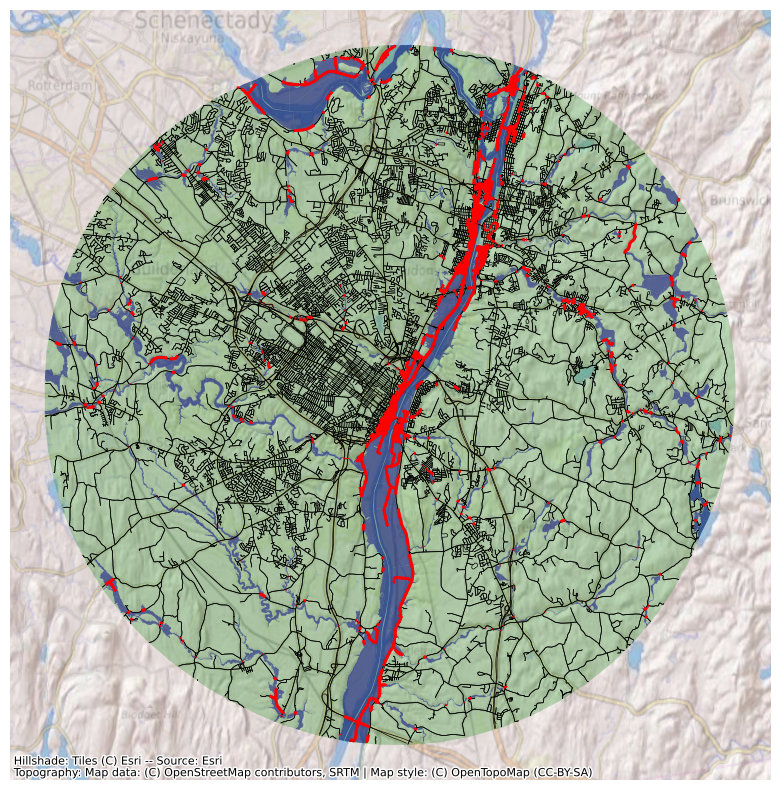

In [18]:
show_gdfs(
    poly_gdfs=[
        # buffered_region_diff_floodplains_gdf,
        buffered_region_gdf,
        floodplains_gdf,
        edges_gdf,
        spatial_join_gdf,
    ],
    colors=['green', 'navy', 'black', 'red'],
    linewidths=[0, 0, 0.5, 2],
    alpha=[0.25, 0.5, 1, 1]
)

In [19]:
original_edges_gdf_columns = list(edges_gdf.columns)

![Floodplain Illustration](https://www.piercecountywa.gov/ImageRepository/Document?documentId=104304)
*From [What is FEMA Floodway and How is it Different?](https://www.piercecountywa.gov/7215/FEMA-Floodway)*

![](https://cdn.sanity.io/images/sqn0ww9a/production/21b9de2adfdb1513966aaec6ecdb6d2876f03df5-843x392.jpg?w=843&h=392&auto=format)
*From [What are the Flood Zones in FEMA Maps - A-X](https://climatecheck.com/risks/flood/what-are-the-flood-zones-in-fema-maps)*

From Google:

> FEMA uses letters to indicate flood risk levels on flood maps:
> 
> * A: High risk areas, also known as Special Flood Hazard Areas (SFHAs) 
> * B: Low risk areas 
> * C: Moderate risk areas 
> * D: Areas with undetermined flood risk 
> * V: Coastal high risk areas 
> * VE: Coastal high risk areas 
> * X: Low and moderate risk areas 
> 
> Explanation
> FEMA flood maps identify flood hazard areas as SFHAs.
> SFHAs are areas that > have a 1% chance of being flooded in any given year,
> also known as the 100-year > flood.
> 
> 
> * https://www.fema.gov/about/glossary/flood-zones
> * https://www.fema.gov/sites/default/files/documents/how-to-read-flood-insurance-rate-map-tutorial.pdf
> * https://www.floodsmart.gov/flood-zones-and-maps
> * https://climatecheck.com/risks/flood/what-are-the-flood-zones-in-fema-maps
> * https://www.allstate.com/resources/flood-insurance/is-your-home-in-a-flood-zone

* https://www.fema.gov/sites/default/files/documents/fema_firm-graphics-guidance.pdf
* https://www.fema.gov/sites/default/files/2020-02/FIRM_Database_Technical_Reference_Feb_2019.pdf

```sql
SELECT
    fld_zone,
    zone_subty,
    count(1) as ct
  FROM merged_floodplains
  GROUP BY 1,2
  ORDER BY 1, 2
;
```

| fld_zone   | zone_subty                                | ct    |
|------------|-------------------------------------------|-------|
| A          | <null>                                    | 12642 |
| AE         | <null>                                    | 43900 |
| AE         | COASTAL FLOODPLAIN                        | 158   |
| AE         | FLOODWAY                                  | 1315  |
| AE         | FW                                        | 275   |
| AE         | RIVERINE FLOODPLAIN IN COASTAL AREA       | 1     |
| AE         | RIVERINE FLOODWAY SHOWN IN COASTAL ZONE   | 30    |
| AH         | <null>                                    | 27    |
| AO         | <null>                                    | 137   |
| AO         | COASTAL FLOODPLAIN                        | 3     |
| OPEN WATER | <null>                                    | 28    |
| V          | <null>                                    | 1     |
| VE         | <null>                                    | 1890  |
| VE         | COASTAL FLOODPLAIN                        | 108   |
| VE         | RIVERINE FLOODWAY SHOWN IN COASTAL ZONE   | 4     |
| X          | 0.2 PCT ANNUAL CHANCE FLOOD HAZARD        | 69256 |
| X          | 1 PCT DEPTH LESS THAN 1 FOOT              | 167   |
| X          | AREA WITH REDUCED FLOOD RISK DUE TO LEVEE | 4     |

In [20]:
"""
Flood Zone Risk Hierarchy:

This dictionary maps FEMA flood zone (fld_zone, zone_subty) pairs to their relative risk ranks.
Lower rank values indicate higher flood risk.

Ranking Logic:

The ranking is based on the severity and frequency of flooding, considering factors such as:
- Coastal vs. riverine flooding: Coastal high-hazard areas (V and VE zones) are ranked highest due to the destructive force of wave action and storm surge.
- Floodways: Floodways (AE with FLOODWAY or FW sub-types) are ranked high due to the high velocity of floodwaters.
- Base Flood Elevation (BFE): Zones with BFEs (AE, VE) are ranked higher than those without (A). VE zones are ranked higher than V zones.
- Shallow flooding: AO and AH zones indicate shallow flooding and are ranked accordingly.
- 0.2% annual chance flood hazard (X zone): These areas are ranked lower than 1% annual chance flood hazard areas (A, AE, VE, etc.).
- Levee protection: Areas with reduced flood risk due to levees (X zone) are ranked lower.
- Open water: Open water is ranked the lowest.

Specific ranking:
1.  VE zones with riverine floodways in coastal zones: Highest risk due to combined wave action and riverine flooding.
2.  VE zones in coastal floodplains: High risk due to wave action.
3.  General VE zones: High risk due to wave action.
4.  V zones: Coastal high hazard, but no specific wave height information.
5.  AE zones with riverine floodways in coastal zones: High risk, but lower than V/VE due to absence of wave action.
6.  AE zones with riverine floodplains in coastal areas.
7.  AE zones with floodways: High risk due to high-velocity floodwaters.
8.  AE zones within coastal floodplains.
9.  AO zones within coastal floodplains.
10. AO zones: Shallow flooding.
11. AE zones: General floodplains.
12. AH zones: Shallow ponding.
13. A zones: 1% annual chance of flooding, but no BFE.
14. X zones with 0.2% annual chance flood hazard.
15. X zones with shallow flooding (less than 1 foot).
16. X zones with levee protection.
17. General X zones: Minimal flood hazard.
18. Open water.

Citations and Resources:
- FEMA Flood Zones: https://www.fema.gov/flood-zones
- FEMA Flood Map Service Center: https://msc.fema.gov/portal/home
- FEMA Guidelines and Standards for Flood Risk Analysis and Mapping: https://www.fema.gov/guidelines-and-standards-flood-risk-analysis-and-mapping
- FEMA P-259, Engineering Principles and Practices for Retrofitting Flood-Prone Residential Structures: https://www.fema.gov/sites/default/files/2020-08/fema259_complete_rev.pdf
- NOAA Coastal Flood Hazard: https://oceanservice.noaa.gov/hazards/natural-hazards/
- Association of State Floodplain Managers (ASFPM): https://www.floods.org/
"""
flood_zone_risk_hierarchy = {
    ("VE", "RIVERINE FLOODWAY SHOWN IN COASTAL ZONE"): 1,
    ("VE", "COASTAL FLOODPLAIN"): 2,
    ("VE", None): 3,
    ("V", None): 4,
    ("AE", "RIVERINE FLOODWAY SHOWN IN COASTAL ZONE"): 5,
    ("AE", "RIVERINE FLOODPLAIN IN COASTAL AREA"): 6,
    ("AE", "FLOODWAY"): 7,
    ("AE", "FW"): 7,  # Treat FW as equivalent to FLOODWAY
    ("AE", "COASTAL FLOODPLAIN"): 8,
    ("AO", "COASTAL FLOODPLAIN"): 9,
    ("AO", None): 10,
    ("AE", None): 11,
    ("AH", None): 12,
    ("A", None): 13,
    ("X", "0.2 PCT ANNUAL CHANCE FLOOD HAZARD"): 14,
    ("X", "1 PCT DEPTH LESS THAN 1 FOOT"): 15,
    ("X", "AREA WITH REDUCED FLOOD RISK DUE TO LEVEE"): 16,
    ("X", None): 17,
    ("OPEN WATER", None): 18,
}

# Make sure that for every fld_zone, there is an entry in the flood_zone_risk_hierarchy where zone_subty is None. 
assert all(
    [(fld_zone, None) in flood_zone_risk_hierarchy for fld_zone, _ in flood_zone_risk_hierarchy.keys()]
)

In [21]:
def get_highest_ranked_flood_zone(flood_zone_pairs):
    """
    Determines the highest ranked flood zone from a list of (fld_zone, zone_subty) pairs.

    The ranking is based on the severity and frequency of flooding, considering factors such as:
    - Coastal vs. riverine flooding: Coastal areas (V and VE zones) are generally ranked higher due to the destructive force of wave action and storm surge.
    - Floodways: Floodways (AE with FLOODWAY or FW sub-types) are ranked high due to the high velocity of floodwaters.
    - Base Flood Elevation (BFE): Zones with BFEs (AE, VE) are ranked higher than those without (A).
    - Shallow flooding: AO and AH zones indicate shallow flooding and are ranked accordingly.
    - 0.2% annual chance flood hazard (X zone): These areas are ranked lower than 1% annual chance flood hazard areas (A, AE, VE, etc.).
    - Levee protection: Areas with reduced flood risk due to levees (X zone) are ranked lower.
    - Open water: Open water is ranked the lowest.

    Specific ranking logic:
    1.  VE zones with riverine floodways in coastal zones are ranked highest due to the combined impact of wave action and riverine flooding.
    2.  VE zones in coastal floodplains are ranked next due to the impact of wave action.
    3.  General VE zones are ranked third due to wave action.
    4.  AE zones with riverine floodways in coastal zones are ranked high, but lower than VE zones due to the absence of wave action.
    5.  AE zones with riverine floodplains in coastal areas are ranked next.
    6.  AE zones with floodways are ranked high due to high-velocity floodwaters.
    7.  AE zones within coastal floodplains are ranked next.
    8.  V zones are ranked next, as they are coastal high hazard, but do not provide specific wave height information.
    9.  AO zones within coastal floodplains are ranked next.
    10. AO zones are ranked next, they represent shallow flooding.
    11. AE zones are ranked next, representing general floodplains.
    12. AH zones are ranked next, representing shallow ponding.
    13. A zones are ranked next, they represent areas with 1% annual chance of flooding, but no BFE.
    14. X zones with 0.2% annual chance flood hazard are ranked next.
    15. X zones with shallow flooding (less than 1 foot) are ranked next.
    16. X zones with levee protection are ranked next.
    17. General X zones are ranked next, representing minimal flood hazard.
    18. Open water is ranked lowest.

    Citations and Resources:
    - FEMA Flood Zones: https://www.fema.gov/flood-zones
    - FEMA Flood Map Service Center: https://msc.fema.gov/portal/home
    - FEMA Guidelines and Standards for Flood Risk Analysis and Mapping: https://www.fema.gov/guidelines-and-standards-flood-risk-analysis-and-mapping
    - FEMA P-259, Engineering Principles and Practices for Retrofitting Flood-Prone Residential Structures: https://www.fema.gov/sites/default/files/2020-08/fema259_complete_rev.pdf
    - NOAA Coastal Flood Hazard: https://oceanservice.noaa.gov/hazards/natural-hazards/
    - Association of State Floodplain Managers (ASFPM): https://www.floods.org/

    Args:
        flood_zone_pairs: A list of tuples, where each tuple is (fld_zone, zone_subty).

    Returns:
        A tuple (fld_zone, zone_subty) representing the highest ranked flood zone, or None if the list is empty.
    """
    if not flood_zone_pairs:
        return None

    highest_rank = float("inf")  # Initialize with a very high value
    highest_ranked_zone = None

    for zone_pair in flood_zone_pairs:
        rank_level = flood_zone_risk_hierarchy.get(
            zone_pair, float("inf")
        )  # If not found, treat as very low risk level.

        if rank_level < highest_rank:
            highest_rank = rank_level
            highest_ranked_zone = zone_pair

    return highest_ranked_zone


Next Prompt:

1. Let's make a TypedDict for the flood_zone_risk_hierarchy data structure.
2. Is `_gs` a good variable name suffix for `road_gs: gpd.GeoSeries`? I want to stick to community paradigms.

In [22]:
def convert_len_value_to_meters(len_value, len_unit):
    """
    Convert a length value to meters based on its unit, handling both coded values and descriptions.

    Args:
        len_value (float, int, or None): The length value in the specified unit.
        len_unit (str or None): The unit, which can be a coded value (e.g., 'FT') or description (e.g., 'Feet').

    Returns:
        float or None: The length in meters, or None if conversion is not possible (e.g., null inputs, invalid unit).

    Raises:
        ValueError: If len_value is non-numeric (except None) or len_unit is invalid and not None.
    """
    # Define conversion factors and mappings based on D_Length_Units
    unit_mappings = {
        # Coded Value: (Description, Conversion Factor to Meters)
        "CM": ("Centimeters", 0.01),
        "FT": ("Feet", 0.3048),
        "IN": ("Inches", 0.0254),
        "KM": ("Kilometers", 1000.0),
        "M": ("Meters", 1.0),
        "MI": ("Miles", 1609.344),
        "MM": ("Millimeters", 0.001),
        "USFT": ("U.S. Survey Feet", 0.3048006096),
        "NP": ("NP", None),
    }

    # Create case-insensitive lookup dictionaries
    code_to_factor = {k.upper(): v[1] for k, v in unit_mappings.items()}
    desc_to_code = {v[0].upper(): k for k, v in unit_mappings.items()}
    # Add coded values to desc_to_code for cases where len_unit might be a coded value
    for code in unit_mappings:
        desc_to_code[code.upper()] = code

    # Handle None inputs
    if len_value is None or len_unit is None:
        return None

    # Validate len_value is numeric
    if not isinstance(len_value, (int, float)):
        raise ValueError("len_value must be a numeric value (int or float) or None.")

    # Handle special case: -9999 as a "no data" value
    if len_value == -9999:
        return None

    # Convert len_unit to uppercase for case-insensitive matching
    len_unit_upper = len_unit.upper()

    # Determine the coded value
    if len_unit_upper in code_to_factor:
        # len_unit is a coded value
        code = len_unit_upper
    elif len_unit_upper in desc_to_code:
        # len_unit is a description
        code = desc_to_code[len_unit_upper]
    else:
        raise ValueError(
            f"Invalid len_unit '{len_unit}'. Must match a coded value or description from D_Length_Units."
        )

    # Handle NP case
    if code == "NP":
        return None

    # Perform conversion
    meters = len_value * code_to_factor[code]
    return meters

In [23]:
def convert_velocity_value_to_meters_per_second(velocity, vel_unit):
    """
    Convert a velocity value to meters per second based on its unit.

    Args:
        velocity (float, int, or None): The velocity value in the specified unit.
        vel_unit (str or None): The unit, which can be a coded value (e.g., 'FPS') or description (e.g., 'Feet per Second').

    Returns:
        float or None: The velocity in meters per second, or None if conversion is not possible.

    Raises:
        ValueError: If velocity is non-numeric (except None) or vel_unit is invalid and not None.
    """
    # Define conversion factors and mappings based on D_Velocity_Units
    unit_mappings = {
        # Coded Value: (Description, Conversion Factor to Meters per Second)
        "FPS": ("Feet per Second", 0.3048),
        "MPS": ("Meters per Second", 1.0),
        "NP": ("NP", None),
    }

    # Create case-insensitive lookup dictionaries
    code_to_factor = {k.upper(): v[1] for k, v in unit_mappings.items()}
    desc_to_code = {v[0].upper(): k for k, v in unit_mappings.items()}
    # Add coded values to desc_to_code for cases where vel_unit might be a coded value
    for code in unit_mappings:
        desc_to_code[code.upper()] = code

    # Handle None inputs
    if velocity is None or vel_unit is None:
        return None

    # Validate velocity is numeric
    if not isinstance(velocity, (int, float)):
        raise ValueError("velocity must be a numeric value (int or float) or None.")

    # Handle special cases: -9999 and -8888 as "no data" values
    if velocity in (-9999, -8888):
        return None

    # Convert vel_unit to uppercase for case-insensitive matching
    vel_unit_upper = vel_unit.upper()

    # Determine the coded value
    if vel_unit_upper in code_to_factor:
        # vel_unit is a coded value
        code = vel_unit_upper
    elif vel_unit_upper in desc_to_code:
        # vel_unit is a description
        code = desc_to_code[vel_unit_upper]
    else:
        raise ValueError(
            f"Invalid vel_unit '{vel_unit}'. Must match a coded value or description from D_Velocity_Units."
        )

    # Handle NP case
    if code == "NP":
        return None

    # Perform conversion
    meters_per_second = velocity * code_to_factor[code]
    return meters_per_second

In [24]:
import geopandas as gpd
import pandas as pd
from typing import Dict, Tuple
import logging
from pyproj import Transformer

# Configure logging (you can customize this)
logging.basicConfig(
    level=logging.WARNING, format="%(asctime)s - %(levelname)s - %(message)s"
)


def create_flood_risk_dataframe(
    spatial_join_gdf: gpd.GeoDataFrame,
    floodplains_gdf: gpd.GeoDataFrame,
    flood_zone_risk_hierarchy: Dict[Tuple[str, str], int] = flood_zone_risk_hierarchy,
) -> pd.DataFrame:
    """
    Creates a DataFrame with flood risk information and intersection lengths (in meters) for each
    road-floodplain intersection, broken down by floodplain type (riverine, floodway)
    and flood recurrence interval (100-year, 500-year).

    Args:
        spatial_join_gdf (gpd.GeoDataFrame):
            GeoDataFrame containing the results of a spatial join between road segments and floodplains,
            with a MultiIndex (road_idx, floodplain_idx).
        floodplains_gdf (gpd.GeoDataFrame):
            GeoDataFrame containing floodplain geometries and attributes.
        flood_zone_risk_hierarchy (Dict[Tuple[str, str], int]):
            A dictionary mapping flood zone (fld_zone, zone_subty) pairs to risk ranks.

    Returns:
        pd.DataFrame: A DataFrame with MultiIndex (road_idx, floodplain_idx) and flood risk information,
                      including intersection lengths (in meters) for various floodplain types
                      and flood recurrence intervals.
    """

    logging.info("Starting flood risk DataFrame creation.")

    results = []  # Initialize results list
    intersection_count = 0

    # Determine a suitable projected CRS (e.g., UTM zone)
    projected_crs = spatial_join_gdf.estimate_utm_crs()

    # Create a transformer for reprojection
    transformer = Transformer.from_crs("epsg:4326", projected_crs, always_xy=True)

    for (road_idx, floodplain_idx), row in spatial_join_gdf.iterrows():
        intersection_count += 1
        floodplain_row = floodplains_gdf.iloc[floodplain_idx]

        fld_zone = floodplain_row["fld_zone"]
        zone_subty = floodplain_row["zone_subty"]
        static_bfe = floodplain_row["static_bfe"]

        depth_m = convert_len_value_to_meters(
            len_value=floodplain_row["depth"],
            len_unit=floodplain_row['len_unit']
        )

        velocity_mps = convert_velocity_value_to_meters_per_second(
            velocity=floodplain_row["velocity"],
            vel_unit=floodplain_row['vel_unit']
        )

        risk_rank = flood_zone_risk_hierarchy.get((fld_zone, zone_subty), None)

        if risk_rank is None:
            logging.warning(
                f"Unrecognized fld_zone/zone_subty: ({fld_zone}, {zone_subty})"
            )

        # Reproject the intersection geometry to the projected CRS
        if isinstance(row.geometry, MultiLineString):
            reprojected_geom = [LineString(zip(*transformer.transform(linestring.xy[0], linestring.xy[1]))) for linestring in row.geometry.geoms]
            reprojected_geom = MultiLineString(reprojected_geom)
            reprojected_geom = gpd.GeoSeries([reprojected_geom], crs=projected_crs).iloc[0]
        else:
            lon, lat = row.geometry.coords.xy
            reprojected_coords = transformer.transform(lon, lat)
            reprojected_geom = gpd.GeoSeries([LineString(zip(reprojected_coords[0], reprojected_coords[1]))], crs=projected_crs).iloc[0]

        intersection_length = round(reprojected_geom.length, 3)

        hundred_year_floodplain = (fld_zone in ("A", "AE", "AH", "AO", "V", "VE")) or (
            fld_zone == "X" and zone_subty == "1 PCT DEPTH LESS THAN 1 FOOT"
        )

        five_hundred_year_floodplain = hundred_year_floodplain or (
            fld_zone == "X" and zone_subty != "1 PCT DEPTH LESS THAN 1 FOOT"
        )

        in_floodway = "FLOODWAY" in str(zone_subty)
        in_riverine = in_floodway or "RIVERINE" in str(zone_subty)

        # Calculate lengths for each combination
        hundred_year_length = (
            intersection_length if hundred_year_floodplain else 0
        )
        five_hundred_year_length = (
            intersection_length if five_hundred_year_floodplain else 0
        )

        hundred_year_riverine_length = (
            intersection_length if hundred_year_floodplain and in_riverine else 0
        )
        five_hundred_year_riverine_length = (
            intersection_length if five_hundred_year_floodplain and in_riverine else 0
        )

        hundred_year_floodway_length = (
            intersection_length if hundred_year_floodplain and in_floodway else 0
        )
        five_hundred_year_floodway_length = (
            intersection_length if five_hundred_year_floodplain and in_floodway else 0
        )

        results.append(
            {
                "road_idx": road_idx,
                "floodplain_idx": floodplain_idx,
                "fld_zone": fld_zone,
                "zone_subty": zone_subty,
                "risk_rank": risk_rank,
                "100_year_floodplain": hundred_year_floodplain,
                "500_year_floodplain": five_hundred_year_floodplain,

                "in_floodway": in_floodway,
                "in_riverine_floodplain": in_riverine,

                "static_bfe": static_bfe,
                "depth_m": depth_m,
                "velocity_mps": velocity_mps,

                "100_year_length_m": hundred_year_length,
                "500_year_length_m": five_hundred_year_length,
                
                "100_year_floodway_length_m": hundred_year_floodway_length,
                "500_year_floodway_length_m": five_hundred_year_floodway_length,

                "100_year_riverine_length_m": hundred_year_riverine_length,
                "500_year_riverine_length_m": five_hundred_year_riverine_length,
            }
        )

    df = pd.DataFrame(results)
    if not df.empty:
        df.set_index(
            keys=["road_idx", "floodplain_idx"], inplace=True, verify_integrity=True
        )

    logging.info(f"Found {intersection_count} intersections.")
    logging.info("Finished flood risk DataFrame creation.")

    return df


In [25]:
flood_risk_df = create_flood_risk_dataframe(
    spatial_join_gdf=spatial_join_gdf,
    floodplains_gdf=floodplains_gdf,
)

In [26]:
def join_spatial_and_risk_data(
    spatial_join_gdf: gpd.GeoDataFrame,
    flood_risk_df: pd.DataFrame,
) -> gpd.GeoDataFrame:
    """
    Joins the spatial join GeoDataFrame with the flood risk DataFrame based on their MultiIndex,
    verifying that the indexes are identical sets and performing an inner join.

    Args:
        spatial_join_gdf (gpd.GeoDataFrame):
            GeoDataFrame with MultiIndex (road_idx, floodplain_idx) and geometry information.
        flood_risk_df (pd.DataFrame):
            DataFrame with MultiIndex (road_idx, floodplain_idx) and flood risk attributes.

    Returns:
        gpd.GeoDataFrame:
            GeoDataFrame with MultiIndex (road_idx, floodplain_idx) and combined geometry and risk data.

    Raises:
        ValueError: If the indexes of the input DataFrames are not identical sets.
    """

    if not set(spatial_join_gdf.index) == set(flood_risk_df.index):
        raise ValueError(
            "Indexes of spatial_join_gdf and flood_risk_df are not identical sets."
        )

    joined_gdf = spatial_join_gdf.join(flood_risk_df, how="inner")
    return joined_gdf


In [27]:
risk_roads_gdf = join_spatial_and_risk_data(
    spatial_join_gdf=spatial_join_gdf,
    flood_risk_df=flood_risk_df
)

In [28]:
def aggregate_flood_risk_by_road_segment(flood_risk_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates the flood risk DataFrame by road segment,
    summing lengths, taking the highest risk rank,
    and handling boolean and categorical values appropriately.

    Args:
        flood_risk_df (pd.DataFrame):
            DataFrame with flood risk information for each road-floodplain intersection.

    Returns:
        pd.DataFrame: DataFrame with aggregated flood risk information by road segment.
    """

    # Reset index to make 'road_idx' a column
    # flood_risk_df_reset = flood_risk_df.copy()
    flood_risk_df_reset = flood_risk_df.reset_index()

    # Sum the lengths
    length_cols = [
        col for col in flood_risk_df_reset.columns if col.endswith("_length_m")
    ]
    df_agg = flood_risk_df_reset.groupby("road_idx")[length_cols].sum()

    df_agg[length_cols] = df_agg[length_cols].round(3)

    # Aggregate risk rank (take the max)
    df_agg["risk_rank"] = flood_risk_df_reset.groupby("road_idx")["risk_rank"].min()

    # Aggregate boolean columns (use any)
    boolean_cols = [
        "100_year_floodplain",
        "500_year_floodplain",
        "in_floodway",
        "in_riverine_floodplain",
    ]
    df_agg[boolean_cols] = flood_risk_df_reset.groupby("road_idx")[boolean_cols].any()

    # Aggregate fld_zone and zone_subty (take the pair with the highest risk rank)
    def agg_fld_zone_and_zone_subty(x):
        # Find the index of the row with the highest risk rank (lowest numerical value)
        max_risk_rank_idx = x["risk_rank"].idxmin(skipna=True)
        return pd.Series(
            {
                "fld_zone": x.loc[max_risk_rank_idx, "fld_zone"],
                "zone_subty": x.loc[max_risk_rank_idx, "zone_subty"],
            }
        )

    # Apply the function only if there are valid risk_rank values
    valid_groups = flood_risk_df_reset.groupby(level=0)["risk_rank"].count() > 0

    df_agg[["fld_zone", "zone_subty"]] = (
        flood_risk_df_reset[
            flood_risk_df_reset.index.get_level_values(0).isin(valid_groups[valid_groups].index)
        ]
        .groupby(
            "road_idx",
        )
        .apply(
            agg_fld_zone_and_zone_subty,
            include_groups=False,
        )
    )

    # Replace NaN with None
    df_agg = df_agg.replace(to_replace=np.nan, value=None)

    assert(
        len(set(flood_risk_df.index.get_level_values(0))) == len(df_agg.index)
    )

    return df_agg

In [29]:
aggregated_df = aggregate_flood_risk_by_road_segment(risk_roads_gdf)

In [30]:
def restore_original_road_index(
    aggregated_df: pd.DataFrame,
    roads_gdf: gpd.GeoDataFrame,
    return_geodataframe: bool = False,
) -> pd.DataFrame | gpd.GeoDataFrame:
    """
    Restores the original (u, v, key) MultiIndex from roads_gdf to the aggregated DataFrame,
    optionally returning a GeoDataFrame with geometries from roads_gdf.

    Args:
        aggregated_df (pd.DataFrame): Aggregated DataFrame with road_idx as index.
        roads_gdf (pd.GeoDataFrame): Original GeoDataFrame with (u, v, key) MultiIndex.
        return_geodataframe (bool, optional): If True, returns a GeoDataFrame with geometries.
                                              Defaults to False.

    Returns:
        pd.DataFrame or gpd.GeoDataFrame: DataFrame or GeoDataFrame with the original (u, v, key) MultiIndex.
    """

    # Create a copy of the aggregated DataFrame
    # result_df = aggregated_df.copy()

    # Extract the original MultiIndex
    original_index = roads_gdf.index

    # Create a mapping from road_idx to original index
    road_idx_to_original = {i: idx for i, idx in enumerate(original_index)}

    # Map the road_idx to the original index
    new_index = aggregated_df.index.map(lambda x: road_idx_to_original[x])

    # Reindex the result DataFrame
    result_df = aggregated_df.copy()
    result_df.reset_index(inplace=True)
    result_df.index = new_index
    result_df.index.set_names(['u', 'v', 'key'], inplace=True)

    if return_geodataframe:
        # Create a GeoDataFrame with geometries from roads_gdf
        result_gdf = gpd.GeoDataFrame(
            result_df, geometry=roads_gdf.loc[result_df.index, "geometry"]
        )
        return result_gdf
    else:
        return result_df


In [31]:
final_gdf = restore_original_road_index(
    aggregated_df=aggregated_df,
    roads_gdf=edges_gdf,
    return_geodataframe=True
)

<Axes: >

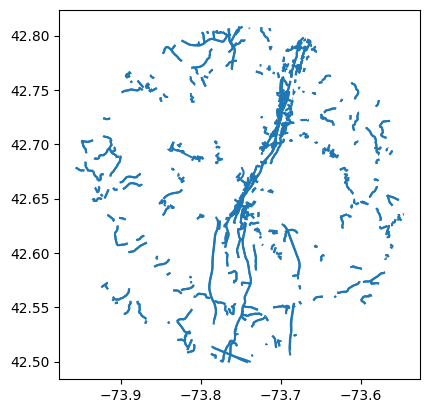

In [32]:
final_gdf.plot()

In [36]:
filename = f'flood_risk_roadways.{region_name}.gpkg'

risk_roads_gdf.to_file(
    filename=filename,
    layer="at_risk_segments",
    driver="GPKG",
    engine="pyogrio",
)

In [37]:
gpd.GeoDataFrame(
    final_gdf.drop(
        columns=['geometry'],
        inplace=False
    )
).to_file(
    filename=filename,
    layer="flood_risk",
    driver="GPKG",
    engine="pyogrio",
)

final_gdf.to_file(
    filename=filename,
    layer="at_risk_roadways",
    driver="GPKG",
    engine="pyogrio",
)

In [38]:
floodplains_gdf.to_file(
    filename=filename,
    layer="floodplains",
    driver="GPKG",
    engine="pyogrio",
)